In [1]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
from multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
from KDEpy import FFTKDE
from tqdm.auto import tqdm
from math import ceil
import itertools
import scipy
from fast_histogram import histogram2d
import colorcet as cc
import matplotlib.colors as colors
import h5py
import io
import cloudpickle as cpl
from collections import defaultdict
import os
from joblib import Parallel, delayed

lmap = lambda func, *iterable: list(map(func, *iterable))

In [2]:
dataset_path = "/data/output/20220226_robustness/dataset.h5"

In [3]:
with h5py.File(dataset_path, "r") as f:
    dX = f["filters"][:].reshape(-1, 9) 

In [4]:
df_meta = pd.read_hdf(dataset_path, "meta")
df_meta["filter_ids"] = df_meta["filter_ids"].apply(lambda s: np.arange(int(s.split(":")[0]), 1 + int(s.split(":")[1])))
df_meta.Robust = df_meta.Robust.apply(bool)

In [5]:
df_pairings = pd.read_csv("robust_vs_normal_pairings.csv", index_col=0)
all_used_model_names = pd.concat([df_pairings.Robust, df_pairings.Normal]).unique()

In [40]:
def get_scaled_filters(ids, limit=32):
    filters = dX[ids[:limit]]
    t = np.abs(filters).max()
    if t == 0:
        return filters
    return filters / t

In [2]:
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_and_save_filter_grid(name, data):
    
    from matplotlib.colors import LinearSegmentedColormap
    
    fig = plt.figure(figsize=(8, 6))
    grid = ImageGrid(fig, 111, nrows_ncols=data.shape[:2], axes_pad=0.0)

    for i, ax in enumerate(grid):
        col_idx = i % data.shape[1]
        row_idx = i // data.shape[1]

        if col_idx == 0:
            ax.set_ylabel(str(row_idx), rotation=0, ha="left", va="center_baseline", labelpad=15)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(data[row_idx, col_idx].reshape(3, 3), cmap=LinearSegmentedColormap.from_list("CyanOrange", ["C0", "white", "C1"]), vmin=-1, vmax=1)
        
    plt.savefig(f"plots/filters/filters_{name}.pdf", bbox_inches='tight')
    return 0

In [ ]:
data.shape[1] / 512

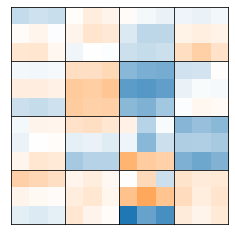

In [48]:
from matplotlib.colors import LinearSegmentedColormap

data = np.stack(df_meta[(df_meta.Name == "robustbench_Addepalli2021Towards_WRN34_cifar10_linf_13") & (df_meta.index.get_level_values("conv_depth_norm") == 1)].filter_ids.apply(lambda x: get_scaled_filters(x, 16)).values)
fig = plt.figure(figsize=(4, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.0)

for i, ax in enumerate(grid):
    row_idx, col_idx  = divmod(i, data.shape[1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(data[row_idx, col_idx].reshape(3, 3), cmap=LinearSegmentedColormap.from_list("CyanOrange", ["C0", "white", "C1"]), vmin=-1, vmax=1)
plt.savefig("/gavrikov/cvpr22w_RobustnessThroughTheLense/plots/last_filters_robust.pdf", bbox_inches='tight')

In [49]:
from matplotlib.colors import LinearSegmentedColormap

data = np.stack(df_meta[(df_meta.Name == "hso_normal_training_robustbench_Addepalli2021Towards_WRN34_cifar10_13") & (df_meta.index.get_level_values("conv_depth_norm") == 1)].filter_ids.apply(lambda x: get_scaled_filters(x, 16)).values)
fig = plt.figure(figsize=(4, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 16), axes_pad=0.0)

for i, ax in enumerate(grid):
    row_idx, col_idx  = divmod(i, data.shape[1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(data[row_idx, col_idx].reshape(3, 3), cmap=LinearSegmentedColormap.from_list("CyanOrange", ["C0", "white", "C1"]), vmin=-1, vmax=1)
plt.savefig("/gavrikov/cvpr22w_RobustnessThroughTheLense/plots/last_filters_normal.pdf", bbox_inches='tight')

In [ ]:
todo = [(model_name, np.stack(df_meta[df_meta.Name == model_name].filter_ids.apply(get_scaled_filters))) for model_name in all_used_model_names]
Parallel(n_jobs=-1)(delayed(plot_and_save_filter_grid)(name, data) for (name, data) in todo)

In [50]:
def plot_and_save_rgb_filter_grid(name, data):
    fig = plt.figure(figsize=(8, 6))
    grid = ImageGrid(fig, 111, nrows_ncols=(data.shape[0] // 16, 16), axes_pad=0.0)
    for i, ax in enumerate(grid):
        col_idx = i % data.shape[0]
        row_idx = i // data.shape[0]

        ax.set_xticks([])
        ax.set_yticks([])

        f = data[i].transpose(1, 2, 0)
        #layer = layer - layer.min()
        f = 0.5+0.5*f/np.abs(data).max()  
        ax.imshow(f)
            
    plt.savefig(f"plots/filters/rgb_filters_{name}.pdf", bbox_inches='tight')

In [ ]:
plot_and_save_rgb_filter_grid(, )

In [ ]:
ids = [(model_name, df_meta.reset_index()[(df_meta.reset_index()["conv_depth"] == 0) & (df_meta.reset_index()["Name"] == model_name)].filter_ids.values) for model_name in all_used_model_names]
todo = [(name, dX[idset[0]].reshape(-1, 3, 3, 3)) for (name, idset) in ids if len(idset) >= 1]
Parallel(n_jobs=-1)(delayed(plot_and_save_rgb_filter_grid)(name, data) for (name, data) in todo)